In [18]:
import numpy as np
import pandas as pd
import math
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as Image
import random
import collections
from skimage import measure, color
from skimage.feature import local_binary_pattern
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

In [3]:
# Set a condition
cdt = 1

# Filename
i = 1
filename = str(i) + ".jpg"

In [4]:
# Read an image (26.jpg as an example)
img = cv2.imread(filename)
show = img[: , : , : : -1]
width = img.shape[1]
height = img.shape[0]
# clear = int(height * 0.3)
clear = 0
# plt.imshow(img)

In [5]:
# Normalize
img = cv2.normalize(img, img, 0, 255, cv2.NORM_MINMAX)
# plt.imshow(img)

In [6]:
S = img.shape[0] * img.shape[1]
window = int(S/4) if int(S/4) % 2 != 0 else int(S/4+1)

# Convert it into binary image
img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

img_G = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                              cv2.THRESH_BINARY, window, 2)

img_M = cv2.adaptiveThreshold(img_gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                              cv2.THRESH_BINARY, window, 2)

ret, img_B = cv2.threshold(img_gray, 127, 255, cv2.THRESH_BINARY)

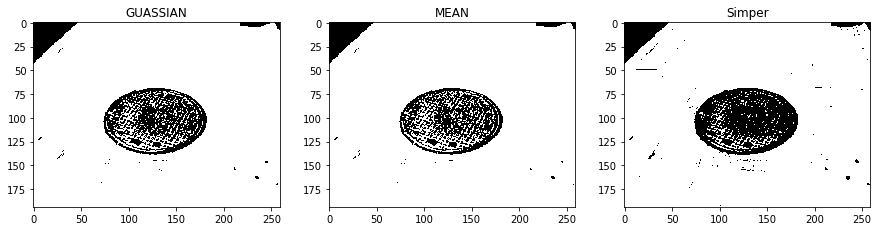

In [7]:
titles = ['GUASSIAN','MEAN','Simper']
imgs =[img_G, img_M, img_B]

fig = plt.figure(figsize=(15, 15))

for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.imshow(imgs[i],'gray')
    plt.title(titles[i])

plt.show()

In [8]:
# Detect the edge of manhole cover
(mu, sigma) = cv2.meanStdDev(img_gray)
edge_A = cv2.Canny(img_gray, mu - sigma, mu + sigma)
edge_G = cv2.Canny(img_G, 0, 255)
edge_M = cv2.Canny(img_M, 0, 255)
edge_B = cv2.Canny(img_B, 0, 255)

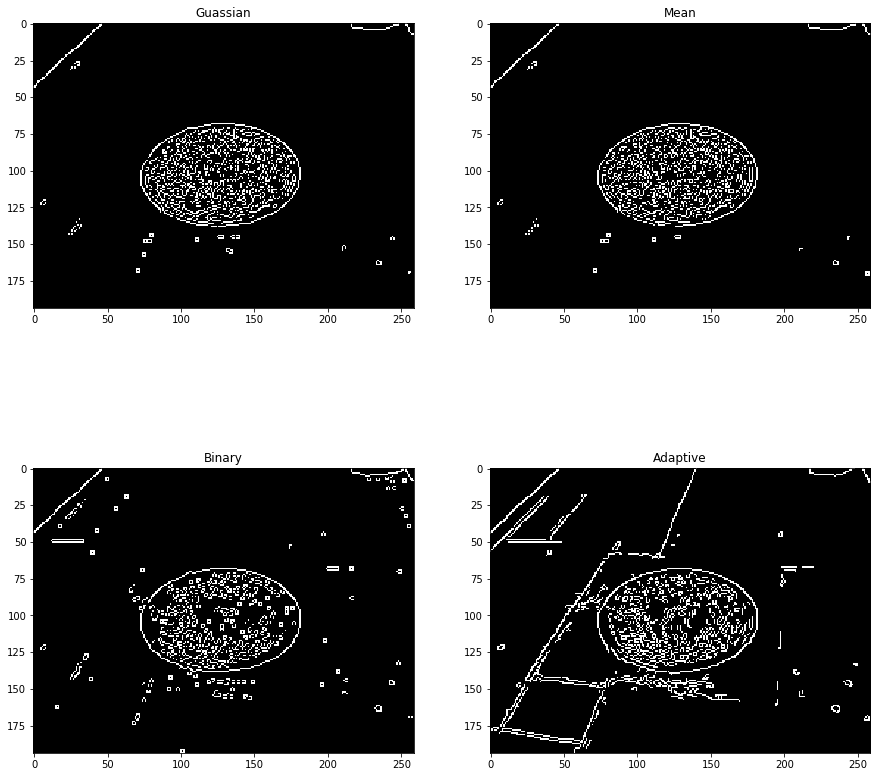

In [9]:
titles = ['Guassian','Mean','Binary','Adaptive']
imgs =[edge_G, edge_M, edge_B, edge_A]

fig = plt.figure(figsize=(15, 15))

for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.imshow(imgs[i],'gray')
    plt.title(titles[i])

plt.show()

In [10]:
b = np.array(edge_B.nonzero())
b.shape[1]

2148

In [11]:
def killLines(edge):
    
    lines = cv2.HoughLines(edge, 1, np.pi/180, int(0.07 * 2 * (edge.shape[0] + edge.shape[1])))
    result = np.zeros(edge.shape, edge.dtype)
    
    if len(lines) != 0:
        for line in lines:
            rho = line[0][0]
            theta= line[0][1]
            if  (theta < (np.pi/4.0)) or (theta > (3.0*np.pi/4.0)):
                pt1 = (int(rho/np.cos(theta)),0)
                pt2 = (int((rho-result.shape[0]*np.sin(theta))/np.cos(theta)),result.shape[0])
                cv2.line( result, pt1, pt2, (255))
            else:
                pt1 = (0,int(rho/np.sin(theta)))
                pt2 = (result.shape[1], int((rho-result.shape[1]*np.cos(theta))/np.sin(theta)))
                cv2.line(result, pt1, pt2, (255), 1)
        delete = np.array(edge & result)
        out = edge - delete
    else:
        out = edge
    
    return out

In [12]:
def findCNT(img):

    cont, hier = cv2.findContours(img, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    cnt = list()
    width = img.shape[1]
    height = img.shape[0]

    S = width * height
    C = (width + height)*2
    Edge_Threshold = int(5)
    Area_Threshold = int(0.01 * S)
    
    
    for i in range(len(cont)):
        if len(cont[i]) > Edge_Threshold:
            ellipse = cv2.fitEllipse(cont[i])
            img_full = np.zeros((height, width,3), img.dtype)
            cv2.ellipse(img_full, ellipse, (1, 0, 0), -1)
            if int(np.sum(img_full)) > Area_Threshold:
                cnt.append(cont[i])
    len(cnt)
        
    return cnt

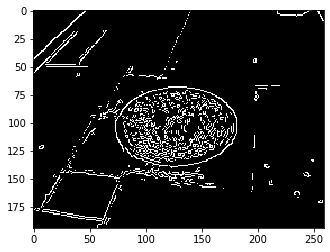

In [13]:
plt.imshow(killLines(edge_A), 'gray')

In [16]:
def saveImg(img, num, name):
    
    if num == 1:
        temp = np.copy(img)
        out = np.expand_dims(temp, axis=2)
        out = np.concatenate((out, out, out), axis=-1)
        out = cv2.normalize(out, out, 0, 255, cv2.NORM_MINMAX)
        out = out.astype('uint8')
        Image.imsave(name, out)
    else:
        temp = np.copy(img)
        out = cv2.normalize(temp, temp, 0, 255, cv2.NORM_MINMAX)
        out = out.astype('uint8')
        Image.imsave(name, out)

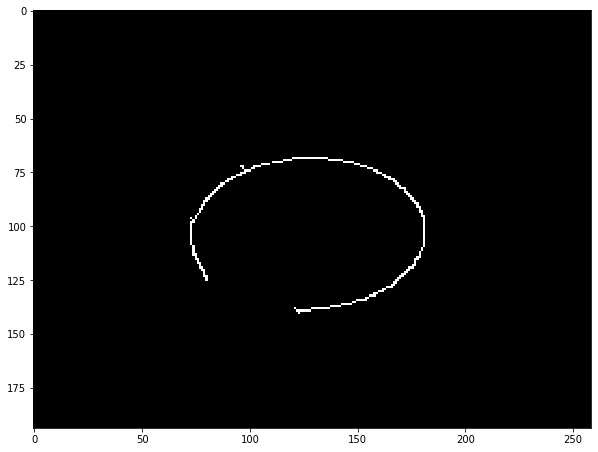

In [15]:
cnt_A = findCNT(killLines(edge_A))
fig = plt.figure(figsize = (10,10))
img_full = np.zeros(edge_A.shape, edge_A.dtype)
for i in range(len(cnt_A)):
    cv2.drawContours(img_full, [cnt_A[i]], 0, (255, 255, 0), -1)
    plt.imshow(img_full, 'gray')

In [20]:
saveImg(img_full, 1, './for Paper/'+ str(i) + '_edge.png')

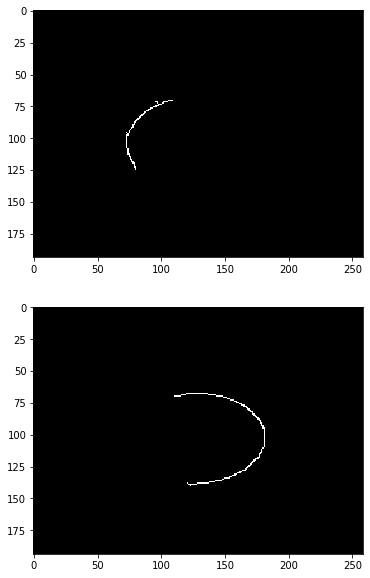

In [32]:
cnt_A = findCNT(killLines(edge_A))
fig = plt.figure(figsize = (10,10))
for i in range(len(cnt_A)):
    img_full = np.zeros(edge_A.shape, edge_A.dtype)
    cv2.drawContours(img_full, [cnt_A[i]], 0, (255, 255, 0), -1)
    plt.subplot(2, (int(len(cnt_A)+1)/2), i+1)
    plt.imshow(img_full, 'gray')

In [33]:
grp_A = cnt_A
for i in range(len(cnt_A)):
    grp_A[i] = cnt_A[i].reshape(cnt_A[i].shape[0], 2)
grp_A[0].shape

(81, 2)

# Ellipse Recognition


In [15]:
def ellipseFunction(grp):
    
    A = np.mat(np.array([np.square(grp[:,0]).astype('float'), 
                         (grp[:,0] * grp[:,1]).astype('float'),
                         np.square(grp[:,1]).astype('float'),
                         grp[:,0].astype('float'),
                         grp[:,1].astype('float')]).T)
    B = np.mat('-1,-1,-1,-1,-1').T
    r = np.array(np.linalg.solve(A,B))
    
    return r

In [16]:
def ellipseParemeters(r):
    
    # the output 'ellipse' is defined as is shown below:
    
    # ((x, y), (a, b), theta)
    ## (x, y) | the location of the center point of the ellipse
    ## (a, b) | the major (a) and minor (b) axe of the ellipse
    ## theta  | the rotation angle of the ellipse
    
    theta = 1/2 * math.atan(r[1]/(r[0]-r[2]))
    center = (((r[1] * r[4] - 2 * r[2] * r[3])/(4 * r[0] * r[2] - math.pow(r[1], 2)))[0], 
          ((r[1] * r[3] - 2 * r[0] * r[4])/(4 * r[0] * r[2] - math.pow(r[1], 2)))[0])
    upper = 2 * (r[0] * math.pow(center[0], 2) + r[2] * math.pow(center[1], 2) + r[1] * center[0] * center[1] - 1)
    index = np.sqrt(np.power((r[0] - r[2]), 2) + np.power(r[1], 2))
    a = (upper[0] / (r[0] + r[2] - index))[0]
    b = (upper[0] / (r[0] + r[2] + index))[0]
    if a > 0:
        if b > 0:
            axes = (2 * np.sqrt(a), 2 * np.sqrt(b))
        else:
            axes = (2 * np.sqrt(a), np.nan)
    else:
        if b > 0:
            axes = (np.nan, 2 * np.sqrt(b))
        else:
            axes = (np.nan, np.nan)
    ellipse = (center, axes, theta)
    
    # and the output 'focuses' is defined as is shown below:
    
    # [[x1, y1], [x2, y2]] | the focuses locations of the ellipse
    
    inner = np.power(ellipse[1][0]/2, 2) - np.power(ellipse[1][1]/2, 2)
    if inner > 0:
        focalLength = np.sqrt(inner)
    else:
        focalLength = np.nan
    focus1 = np.array([ellipse[0][0] + focalLength * np.cos(np.pi * ellipse[2] / 180), ellipse[0][1] + focalLength * np.sin(np.pi * ellipse[2] / 180)])
    focus2 = np.array([ellipse[0][0] - focalLength * np.cos(np.pi * ellipse[2] / 180), ellipse[0][1] - focalLength * np.sin(np.pi * ellipse[2] / 180)])
    focuses = np.array([focus1, focus2])
    
    return (ellipse, focuses)

In [17]:
def randPoints(x):
    
    # used to select five points randomly
    
    def maxPoints(points): 
        
        # used to prevent getting points lying in a same line
        
        answer = 0
        
        for p in points:
            pctr = 0
            ctr = collections.Counter()
            
            for q in points:
                x, y = q[0] - p[0], q[1] - p[1]
                pctr += x == y == 0
                ctr[float(y)/x if x else 'inf'] += 1
                
            ctr['inf'] -= pctr
            
            answer = max(answer, pctr + max(ctr.values()))
            
        return answer
    
    def killNeighbors(points):
        
        # used to prevent getting adjacent points
        
        condition = 0
        
        for i in range(points.shape[0] - 1):
            for j in range(i+1, points.shape[0]):
                if ((points[i][0] - points[j][0]) * (points[i][1] - points[j][1]) == 0):
                    condition = condition + 1
                    
        return condition
        
    points = np.array([[1,1],[2,2],[3,3],[3,4]])

    while ((maxPoints(points) > 2) | (killNeighbors(points) > 0)):
        
        rand = random.sample(list(range(0, x.shape[0])), 5)
        points = np.zeros((len(rand), x.shape[1]))
    
        for i in range(len(rand)):
            points[i] = x[rand[i]]
        
        points = points.astype(int)
        
    return points

In [18]:
def vote(points, r):
    
    (ellipse, focuses) = ellipseParemeters(r)
    vote = 0
    voter = list()
    
    for p in points:
        distance = np.sqrt(np.power(p[0] - focuses[0][0], 2) + np.power(p[1] - focuses[0][1], 2)) + np.sqrt(np.power(p[0] - focuses[1][0], 2) + np.power(p[1] - focuses[1][1], 2))
        if (-2 < ellipse[1][0] - distance < 2): 
            vote = vote + 1
            voter.append([p[0], p[1]])
            
    return (vote, voter)

In [19]:
def oneEllipse(group, P):
    
    points = list()
    for i in range(len(P)):
        for p in P[i]:
            points.append(p)
    points = np.array(points)
    
    ellipse = ((0, 0),(0, 0), np.nan)
    num = 0
    
    while(np.isnan(ellipse[0][0] * ellipse[0][1] * ellipse[1][0] * ellipse[1][1] * ellipse[2]) | num < int(len(points) * 1/3)):
        random = randPoints(group)
        function = ellipseFunction(random)
        (num, voters) = vote(points, function)
        
    return (num, voters, function)

In [20]:
def bestEllipse(group, P, times):
    
    numbers = np.zeros([times, 1])
    
    for i in range(times):
        (n, v, f) = oneEllipse(group, P)
        numbers[i] = n
        if n == int(max(numbers)):
            num = n
            voters = v
            function = f
    
    return (num, voters, function)

In [21]:
def IOU(img1, img2):
    
    I = int(np.sum(img1 & img2))
    U = int(np.sum(img1 | img2))
    out = round((I / U), 4)
    
    return out

In [22]:
def arcSplice(img, P, times):
    
    N = list()
    V = list()
    F = list()
    E = list()
    O = list()
    
    for i in range(len(P)):
        (num, voters, function) = bestEllipse(P[i], P, times)
        (ellipse, focuses) = ellipseParemeters(function)
        N.append(num)
        V.append(voters)
        F.append(function)
        E.append(ellipse)
        O.append(focuses)
        
    # to detect if the ellipses are actually the same one
    
    # calculate the IoU of every two eclipses
    pics = list()
    delete = list()
    img = np.zeros((img.shape[0], img.shape[1]), img.dtype)
    for i in range (len(P)):
        cv2.ellipse(img, E[i], (1, 0, 0), -1)
        pics.append(img)
    for i in range(len(pics)-1):
        for j in range(i+1, len(pics)):
            iou = IOU(pics[0], pics[1])
            if iou > 0.95:
                delete.append(i)
                delete.append(j)
                
                N.append(N[i] + N[j])
                V.append(V[i] + V[j])
                func = (N[i]*F[i] + N[j]*F[j])/(N[i]+N[j])
                F.append(func)
                (elli, focu) = ellipseParemeters(func)
                E.append(elli)
                O.append(focu)
    
    for i in range(len(delete)):
        N.pop(i)
        V.pop(i)
        F.pop(i)
        E.pop(i)
        O.pop(i)
                
    return (N, V, F, E, O)

In [23]:
(N, V, F, E, O) = arcSplice(img, grp_A, 50)

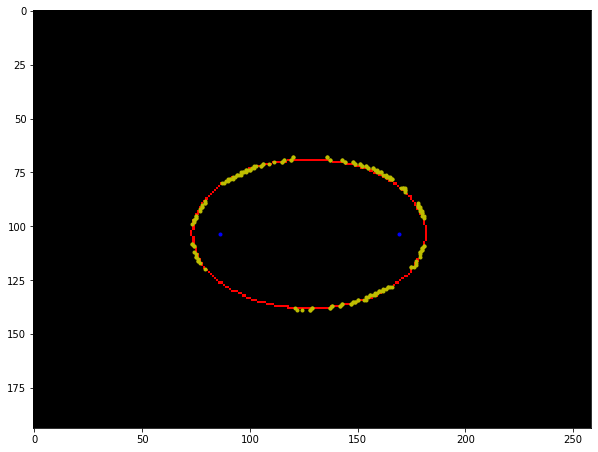

In [26]:
fig = plt.figure(figsize = (10,10))
temp = np.zeros(img.shape, img.dtype)
cv2.ellipse(temp, E[0], (255, 0, 0), 1)
plt.plot(O[0][:, 0], O[0][:, 1], 'b.', label = "Focuses")
plt.plot(np.array(V[0])[:, 0], np.array(V[0])[:, 1], 'y.', label = "Voters")
plt.imshow(temp)